### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net2Loops.inp`. Let's start by setting up the model:

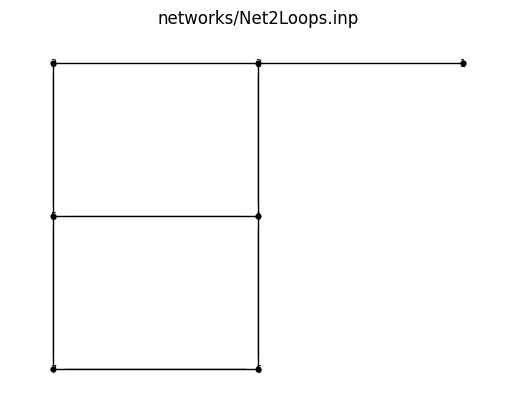

{'duration': 0.0,
 'hydraulic_timestep': 3600,
 'quality_timestep': 300,
 'rule_timestep': 360,
 'pattern_timestep': 7200,
 'pattern_start': 0.0,
 'report_timestep': 3600,
 'report_start': 0.0,
 'start_clocktime': 0.0,
 'statistic': 'NONE',
 'pattern_interpolation': False}

In [1]:
import os
from pathlib import Path
import wntr
import wntr_quantum

epanet_tmp_dir = Path("/Users/murilo/scratch_dir/vqls_solver_net2loops")
if not epanet_tmp_dir.exists():
    epanet_tmp_dir.mkdir(parents=True, exist_ok=True)

os.environ["EPANET_TMP"] = str(epanet_tmp_dir)
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = 'networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

# explicitly set Darcy-Weisbach head loss formulas and pressure dependent demand mode
wn.options.hydraulic.headloss = 'H-W'
wn.options.hydraulic.demand_model = 'PDD'

# required pressure: the pressure above which the consumer should receive the desired demand
wn.options.hydraulic.required_pressure = 30.00 # m
# minimum pressure: this is the pressure below which the consumer cannot receive any water
wn.options.hydraulic.minimum_pressure  = 5.00  # m

# set time duration of the simulation (in seconds)
wn.options.time.duration = 0

# print options
dict(wn.options.hydraulic)
dict(wn.options.time)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [2]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

# load EPANET A and b matrices from temp
epanet_A, epanet_b = wntr_quantum.sim.epanet.load_epanet_matrix()

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/vqls_solver_net2loops

Size of the Jacobian in EPANET simulator: 6
Size of the b vector in EPANET simulator: 6


(name          2          3          4          5          6          7  \
 0     53.374657  30.983078  44.534256  29.516634  30.857758  27.850245   
 
 name             1  
 0     4.394531e-07  ,
 name         1         2         3         4         5         6         7  \
 0     0.307917  0.051032  0.229115  0.031428  0.164357  0.072689  0.023263   
 
 name        8  
 0    -0.01958  )

### Solve linear system with VQLS and the final matrices from EPANET

For testing purposes, we start by solving the linear system with VQLS and the final A and b matrices from the classical EPANET simulator. Here, we are **preconditioning** the initial linear system using diagonal scaling and also using a **mix of two classical optimizers**.

In [3]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="pauli",
    verbose=True,
    preconditioner="diagonal_scaling",
    reorder=True,
)

res = linear_solver(epanet_A, epanet_b)

100%|██████████| 64/64 [00:00<00:00, 4968.54it/s]


VQLS Iteration 1000 Cost 1.838e-04
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 1.838430E-04    MAXCV = 0.000000E+00
   X =-2.998589E-01   2.722273E-01  -1.860267E-01   3.293352E+00  -7.855195E-01
      -2.365456E-01  -1.365717E+00  -2.620859E+00  -2.546005E+00   2.455771E+00
       2.811983E+00  -1.395428E+00


100%|██████████| 64/64 [00:00<00:00, 5060.43it/s]


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 520
         Gradient evaluations: 40


Let's check the evolution of the cost function

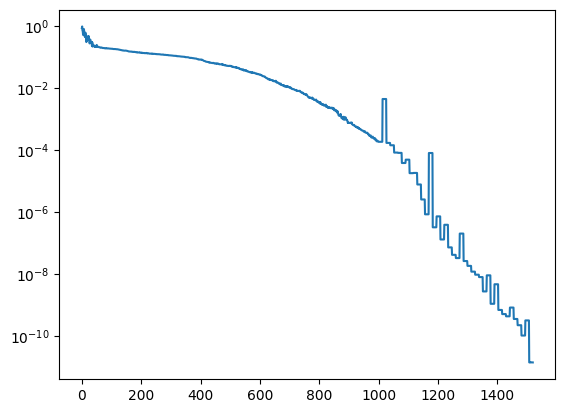

In [4]:
import matplotlib.pyplot as plt
plt.semilogy(res.logger.values)

and visualize graphically the solution

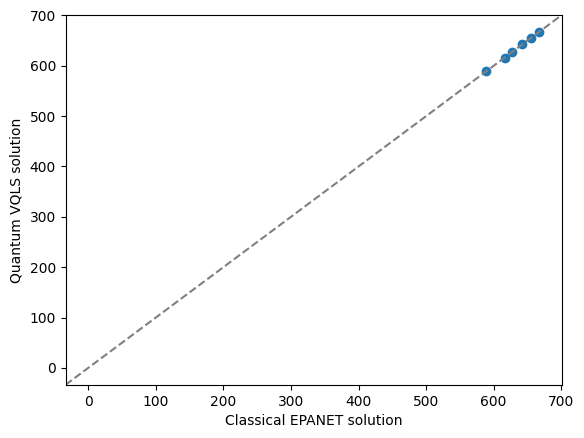

(array([616.307, 642.578, 654.64 , 667.24 , 626.585, 588.965]),
 array([616.303, 642.577, 654.64 , 667.239, 626.581, 588.962]))

In [5]:
import numpy as np 
ref = np.linalg.solve(epanet_A.todense(), epanet_b)

plt.scatter(ref, res.solution)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.xlabel("Classical EPANET solution")
plt.ylabel("Quantum VQLS solution")
plt.show()

ref, res.solution